참고링크: https://python-visualization.github.io/folium/quickstart.html

In [ ]:
import folium # 평점 높은 가게 매핑해볼 수도 있겠다.

m = folium.Map(location=[18.915421, -99.184871])
tooltip = 'test'
folium.Marker([18.915421, -99.184871], tooltip= tooltip).add_to(m)

m

# data load

In [1]:
import pandas as pd
import os

dataPath = 'data/'
listDir = os.listdir(dataPath)
print(listDir)

['chefmozaccepts.csv', 'chefmozcuisine.csv', 'chefmozhours4.csv', 'chefmozparking.csv', 'chefmozparking_new.csv', 'geoplaces2.csv', 'rating_final.csv', 'README', 'usercuisine.csv', 'userpayment.csv', 'userprofile.csv']


1. 손님의 위치와 가게의 거리 차이. con_3에 교통수단 정보 있음.
2. 생각보다 쓸 수 있는 데이터의 크기가 작다. 130개정도. 따라서 GradientBoost 계열을 쓰기엔 어렵다.
3. 데이터 분석 방법을 바꿔야하나? 고객-상점 간의 관계를 볼 수 있는건 130개
4. 그냥 가게끼리 군집화 해볼 수 있겠다. 높은 상점의 특성을 살펴보기
5. 시각화까지. 

In [2]:
rating = pd.read_csv(dataPath + '/' + listDir[6]) # 가게 점수.

In [3]:
rest_1 = pd.read_csv(dataPath + '/' + listDir[0]) # 지불종류
#rest_2 = pd.read_csv(dataPath + '/' + listDir[1]) # 요리 종류
rest_2 = pd.read_csv('rest_2_new.csv')
rest_3 = pd.read_csv(dataPath + '/' + listDir[2]) # 영업시간, 요일 
rest_4 = pd.read_csv(dataPath + '/' + listDir[4]) # 주차장 유무
#rest_4_new = pd.read_csv(dataPath + '/' + listDir[4])
rest_5 = pd.read_csv(dataPath + '/' + listDir[5]) # 가게 정보(이름, 위치, 위도, 경도, 가격)

In [11]:
con_1 = pd.read_csv(dataPath + '/' + listDir[8]) # 손님이 섭취한 음식종류
con_2 = pd.read_csv(dataPath + '/' + listDir[9]) # 지불 종류
con_3 = pd.read_csv(dataPath + '/' + listDir[10]) # 손님의 정보 (위치, 흡연유무, 음주정도, 교통수단정보, 직업정보, 종교)

In [46]:
def findrestLoc(placeID):
    return rest_5[rest_5['placeID']==placeID][['latitude', 'longitude']]

In [42]:
def findPlaceID(userID):
    return rating[rating['userID'] == userID]['placeID']

# data preprocessing

## rating 

In [7]:
rating['mean_rating'] = ( rating['rating'] + rating['food_rating'] + rating['service_rating'] ) / 3
rating = rating.groupby(['placeID'])[['mean_rating', 'rating', 'food_rating','service_rating']].mean().reset_index()
rating.head()

,placeID,mean_rating,rating,food_rating,service_rating
0,132560,0.583333,0.500000,1.000000,0.250000
1,132572,0.977778,1.000000,1.000000,0.933333
2,132584,1.277778,1.333333,1.500000,1.000000
3,132594,0.800000,0.600000,1.200000,0.600000
4,132608,1.000000,1.000000,1.166667,0.833333


In [4]:
set_rating = set(rating['placeID'].unique())

## rest 통일하기
placeID 맞게 통일시켜야 됨. 겹쳐있는 정보 하나로 합쳐야됨.

rest_1 -> 지불종류에 대한 정보. 평점에 큰 영향은 없다고 판단되어 사용하지 않기로 함.

In [20]:
print(len(rest_1.placeID.unique())) # 사용안함
print(len(rest_2.placeID.unique())) # 음식종류 하나로 합칠 필요가 있음.
print(len(rest_3.placeID.unique())) # days -> 평일, 주말, 7일내내. 로 바꿔줄 필요가 있음. housrs -> 시간종류로 바꿔주기
print(len(rest_4.placeID.unique())) # 주차장 종류 
print(len(rest_5.placeID.unique())) # 1
print(len(rating['placeID'].unique()))

615
769
694
675
130
130


In [5]:
set_1 = set(rest_1.placeID.unique())
set_2 = set(rest_2.placeID.unique())
set_3 = set(rest_3.placeID.unique())
set_4 = set(rest_4.placeID.unique())
set_5 = set(rest_5.placeID.unique())

In [16]:
len(set_intersection)

85

In [6]:
set_intersection = set_2.intersection(set_4, set_5, set_rating)
rating = rating[rating['placeID'].apply(lambda x : x in set_intersection)].reset_index(drop=True)
print(rating.shape)

(815, 5)


In [14]:
no_rating = set_2.intersection(set_4, set_5)
len(no_rating)

85

rating의 placeID와 rest_5의 placeID는 같다. 따라서 rest_5에 맞춰서 다른 것들 다 뺴줘야됨 

### rest_2 전처리
rating에 rest_2 더해주기

In [ ]:
one-hot encoding

In [199]:
rest_2 = rest_2[rest_2['placeID'].apply(lambda x : x in set_intersection)].reset_index(drop=True)

In [203]:
display(rating.head(), rest_2.head())

,placeID,mean_rating
0,132560,0.583333
1,132572,0.977778
2,132584,1.277778
3,132594,0.800000
4,132608,1.000000


,placeID,Rcuisine
0,135109,Italian
1,135106,Mexican
2,135104,Mexican
3,135088,Cafeteria
4,135086,Burgers


In [197]:
rest_2.shape

(99, 2)

In [206]:
a = pd.crosstab(rest_2['placeID'], 'count')
b = list(a[a['count']>=2].index)

In [221]:
b

[132773,
 132851,
 132866,
 134983,
 135030,
 135032,
 135041,
 135043,
 135052,
 135053,
 135071,
 135073,
 135086]

In [97]:
rest_2[rest_2['placeID'].apply(lambda x : x in b)].shape

(27, 2)

In [243]:
temp = pd.get_dummies(rest_2)

In [208]:
a = list(temp[temp['placeID'].apply(lambda x : x in b)].index)

In [209]:
a.remove(22)
a.remove(23)
a.remove(24)

In [210]:
q = [a[i] for i in range(0, len(a), 2)]
q

[4, 10, 13, 25, 31, 34, 39, 41, 48, 63, 70, 76]

In [236]:
def t(i): 
    temp.iloc[i, 1:] += temp.iloc[i+1, 1:]
    temp.drop(i+1, inplace=True)

In [244]:
for i in q:
    t(i)

temp.iloc[22, 1:] += temp.iloc[23, 1:] + temp.iloc[23, 1:]
temp.drop([23, 24], inplace=True)

In [ ]:
id, value
1 2
1 3

id value_2 value_3
1   1            0
1   0            1     

1   1           1

In [245]:
temp[temp['placeID'].apply(lambda x : x in b)]

,placeID,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,...,Rcuisine_Fast_Food,Rcuisine_Game,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Mexican,Rcuisine_Pizzeria,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Vietnamese
4,135086,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
10,135073,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,135071,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,135053,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
25,135052,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
31,135043,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
34,135041,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,135032,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
41,135030,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
48,134983,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### rest_4 전처리

In [272]:
rest_4 = rest_4[rest_4['placeID'].apply(lambda x : x in set_intersection)].reset_index(drop=True)

In [273]:
rest_4.shape # 있음 

(85, 2)

In [34]:
print(len(rest_4['placeID'].unique()))
print(len(rest_4))
print(len(rest_3['placeID'].unique()))

675
702
694


In [25]:
a = pd.crosstab(rest_4['placeID'], 'count')
index = list(a[a['count']>=2].index)

In [40]:
a = list(rest_4[rest_4['placeID'].apply(lambda x : x in index)].index) #우선순위. public, street, fee. 

### rest_5 전처리

In [150]:
rest_5

,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,zip,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,?,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none
1,132825,22.147392,-100.983092,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,78280,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,open,none
2,135106,22.149709,-100.976093,0101000020957F0000649D6F21634858C119AE9BF528A3...,El Rinc�n de San Francisco,Universidad 169,San Luis Potosi,San Luis Potosi,Mexico,?,78000,Wine-Beer,only at bar,informal,partially,medium,?,familiar,f,open,none
3,132667,23.752697,-99.163359,0101000020957F00005D67BCDDED8157C1222A2DC8D84D...,little pizza Emilio Portes Gil,calle emilio portes gil,victoria,tamaulipas,?,?,?,No_Alcohol_Served,none,informal,completely,low,?,familiar,t,closed,none
4,132613,23.752903,-99.165076,0101000020957F00008EBA2D06DC8157C194E03B7B504E...,carnitas_mata,lic. Emilio portes gil,victoria,Tamaulipas,Mexico,?,?,No_Alcohol_Served,permitted,informal,completely,medium,?,familiar,t,closed,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,132866,22.141220,-100.931311,0101000020957F000013871838EC4A58C1B5DF74F8E396...,Chaires,Ricardo B. Anaya,San Luis Potosi,San Luis Potosi,Mexico,?,?,No_Alcohol_Served,not permitted,informal,completely,medium,?,familiar,f,closed,none
126,135072,22.149192,-101.002936,0101000020957F0000E7B79B1DB94758C1D29BC363D8AA...,Sushi Itto,Venustiano Carranza 1809 C Polanco,San Luis Potosi,SLP,Mexico,?,78220,No_Alcohol_Served,none,informal,no_accessibility,medium,sushi-itto.com.mx,familiar,f,closed,none
127,135109,18.921785,-99.235350,0101000020957F0000A6BF695F136F5AC1DADF87B20556...,Paniroles,?,?,?,?,?,?,Wine-Beer,not permitted,informal,no_accessibility,medium,?,quiet,f,closed,Internet
128,135019,18.875011,-99.159422,0101000020957F0000B49B2E5C6E785AC12F9D58435241...,Restaurant Bar Coty y Pablo,Paseo de Las Fuentes 24 Pedregal de Las Fuentes,Jiutepec,Morelos,Mexico,?,?,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,closed,none


In [149]:
rest_5 = pd.read_csv(dataPath + '/' + listDir[5]) # 가게 정보(이름, 위치, 위도, 경도, 가격)

In [314]:
rest_5 = rest_5[rest_5['placeID'].apply(lambda x : x in set_intersection)].reset_index(drop=True)
rest_5.rename(columns={'Rambience':'ambience'}, inplace=True)
rest_5 = rest_5[['placeID', 'price', 'smoking_area', 'alcohol', 'dress_code', 'other_services', 'area', 'franchise', 'ambience']]

price, smoking_area, alcohol, dress_code, other_services, area, franchise, ambience

In [317]:
rest_5.shape

(85, 9)

## rating + rest

In [326]:
rating = rating.sort_values(by='placeID').reset_index(drop=True)
rest_2 = rest_2.sort_values(by='placeID').reset_index(drop=True)
rest_4 = rest_4.sort_values(by='placeID').reset_index(drop=True)
rest_5 = rest_5.sort_values(by='placeID').reset_index(drop=True)

In [332]:
rest_2 = rest_2.iloc[:, 1:]
rest_4 = rest_4.iloc[:, 1:]
rest_5 = rest_5.iloc[:, 1:]

In [333]:
display(rating.head(3), rest_2.head(3), rest_4.head(3), rest_5.head(3))

,placeID,mean_rating
0,132560,0.583333
1,132572,0.977778
2,132584,1.277778


,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_Chinese,...,Rcuisine_Fast_Food,Rcuisine_Game,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Mexican,Rcuisine_Pizzeria,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Vietnamese
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


,parking_lot
0,public
1,yes
2,yes


,price,smoking_area,alcohol,dress_code,other_services,area,franchise,ambience
0,low,permitted,No_Alcohol_Served,informal,none,open,f,familiar
1,low,not permitted,No_Alcohol_Served,informal,none,closed,f,familiar
2,medium,not permitted,No_Alcohol_Served,informal,none,closed,t,familiar


In [335]:
total = pd.concat([rating, rest_2, rest_4, rest_5], axis=1)

In [338]:
total.to_csv('total.csv', index=False)

## con

고객의 선호도에 대한 정보가 담겨있다. 추천해줄 수 있지 않을까?

In [256]:
con_1 = pd.read_csv(dataPath + '/' + listDir[8]) # 손님이 섭취한 음식종류
con_2 = pd.read_csv(dataPath + '/' + listDir[9]) # 지불 종류
con_3 = pd.read_csv(dataPath + '/' + listDir[10]) # 손님의 정보 (위치, 흡연유무, 음주정도, 교통수단정보, 직업정보, 종교)

In [178]:
rating_ = pd.read_csv(dataPath + '/' + listDir[6]) # 가게 점수.
rest_2_ = pd.read_csv(dataPath + '/' + listDir[1]) # 요리 종류

In [215]:
len(rest_2_['Rcuisine'].unique())

59

In [205]:
display(con_1.head(), con_2.head(), con_3.head())

,userID,Rcuisine
0,U1001,American
1,U1002,Mexican
2,U1003,Mexican
3,U1004,Bakery
4,U1004,Breakfast-Brunch


,userID,Upayment
0,U1001,cash
1,U1002,cash
2,U1003,cash
3,U1004,cash
4,U1004,bank_debit_cards


,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69


In [227]:
con_3.shape

(138, 19)

In [208]:
intersection = list(set(con_1['userID']).intersection(set(con_3['userID'])))
len(intersection)

138

In [219]:
intersect_cuisine = set(con_1['Rcuisine'].unique()).intersection(set(rest_2_['Rcuisine'].unique()))
len(intersect_cuisine)

59

In [310]:
con1 = con_1[con_1['Rcuisine'].apply(lambda x : x in intersect_cuisine)]
con1 = con1[con1['userID'].apply(lambda x : x in intersection)]
con1 = pd.get_dummies(con1, columns=['Rcuisine'])

In [263]:
a = pd.crosstab(con1['userID'], 'count') 
b = list(a[a['count']>2].index)

In [332]:
c = con1[con1['userID'].apply(lambda x: x in b)]

In [333]:
c['userID'].unique()

array(['U1004', 'U1008', 'U1009', 'U1016', 'U1021', 'U1060', 'U1101',
       'U1108', 'U1128', 'U1135'], dtype=object)

In [394]:
con1[con1['userID']=='U1135']

,userID,Rcuisine_Afghan,Rcuisine_African,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Asian,Rcuisine_Bagels,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Barbecue,Rcuisine_Brazilian,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_California,Rcuisine_Caribbean,Rcuisine_Chinese,Rcuisine_Contemporary,Rcuisine_Continental-European,Rcuisine_Deli-Sandwiches,Rcuisine_Dessert-Ice_Cream,Rcuisine_Diner,Rcuisine_Dutch-Belgian,Rcuisine_Eastern_European,Rcuisine_Ethiopian,Rcuisine_Family,Rcuisine_Fast_Food,Rcuisine_Fine_Dining,Rcuisine_French,Rcuisine_Game,Rcuisine_German,Rcuisine_Greek,Rcuisine_Hot_Dogs,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Juice,Rcuisine_Korean,Rcuisine_Latin_American,Rcuisine_Mediterranean,Rcuisine_Mexican,Rcuisine_Mongolian,Rcuisine_Organic-Healthy,Rcuisine_Persian,Rcuisine_Pizzeria,Rcuisine_Polish,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Soup,Rcuisine_Southern,Rcuisine_Southwestern,Rcuisine_Spanish,Rcuisine_Steaks,Rcuisine_Sushi,Rcuisine_Thai,Rcuisine_Turkish,Rcuisine_Vegetarian,Rcuisine_Vietnamese
138,U1135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [392]:
for i in range(1, 59):
    con1.iloc[138, 1:] += con1.iloc[138+i, 1:] 

In [393]:
for i in range(1, 59):
    con1.drop(138+i, inplace=True)

In [395]:
con1.to_csv('new_con_1.csv', index=False)

In [397]:
con_3

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,U1134,22.149654,-100.998610,false,casual drinker,no preference,family,public,single,independent,1991,variety,hard-worker,Catholic,student,black,52,medium,1.65
134,U1135,22.170396,-100.949936,false,casual drinker,informal,family,on foot,single,kids,1988,variety,hunter-ostentatious,Catholic,student,purple,66,low,1.54
135,U1136,22.149607,-100.997235,true,social drinker,no preference,friends,car owner,single,independent,1990,retro,thrifty-protector,Catholic,student,black,50,low,1.60
136,U1137,22.144803,-100.944623,false,social drinker,formal,family,public,single,independent,1989,eco-friendly,hard-worker,Catholic,student,blue,72,low,1.78


In [404]:
con3 = con_3[['userID', 'latitude', 'longitude', 'smoker', 'dress_preference', 'ambience', 'transport', 'budget']]

In [482]:
con3 = con3.reset_index(drop=True)

In [483]:
display(con1.head(), con3.iloc[:, 1:].head())

,userID,Rcuisine_Afghan,Rcuisine_African,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Asian,Rcuisine_Bagels,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Barbecue,Rcuisine_Brazilian,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_California,Rcuisine_Caribbean,Rcuisine_Chinese,Rcuisine_Contemporary,Rcuisine_Continental-European,Rcuisine_Deli-Sandwiches,Rcuisine_Dessert-Ice_Cream,Rcuisine_Diner,Rcuisine_Dutch-Belgian,Rcuisine_Eastern_European,Rcuisine_Ethiopian,Rcuisine_Family,Rcuisine_Fast_Food,Rcuisine_Fine_Dining,Rcuisine_French,Rcuisine_Game,Rcuisine_German,Rcuisine_Greek,Rcuisine_Hot_Dogs,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Juice,Rcuisine_Korean,Rcuisine_Latin_American,Rcuisine_Mediterranean,Rcuisine_Mexican,Rcuisine_Mongolian,Rcuisine_Organic-Healthy,Rcuisine_Persian,Rcuisine_Pizzeria,Rcuisine_Polish,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Soup,Rcuisine_Southern,Rcuisine_Southwestern,Rcuisine_Spanish,Rcuisine_Steaks,Rcuisine_Sushi,Rcuisine_Thai,Rcuisine_Turkish,Rcuisine_Vegetarian,Rcuisine_Vietnamese
0,U1001,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,U1002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,U1003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,U1004,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,U1005,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,latitude,longitude,smoker,dress_preference,ambience,transport,budget
0,22.139997,-100.978803,false,informal,family,on foot,medium
1,22.150087,-100.983325,false,informal,family,public,low
2,22.119847,-100.946527,false,formal,family,public,low
3,18.867000,-99.183000,false,informal,family,public,medium
4,22.183477,-100.959891,false,no preference,family,public,medium


In [485]:
total = pd.concat([con1, con3.iloc[:, 1:]], axis=1)

In [489]:
total.to_csv('total_con.csv', index=False)

# 추천 알고리즘 구현
- 위도, 경도 거리 계산해서 transport적용하기. 
- smoker -> 흡연실 여부
- drink_level
- dress_preference
- ambience
- 

위도 경도 거리 계산하는 법  
X = ( cos( 위도#1 ) * 6400 * 2 * 3.14 / 360 ) * | 경도#1 - 경도#2 |

Y = 111 * | 위도#1 - 위도#2 |

D = √ ( X² + Y² )  
[출처] 위도, 경도로 거리 계산 공식|작성자 까미유

## con_total

In [19]:
rating = pd.read_csv(dataPath + '/' + listDir[6]) # 가게 점수.
con_total = pd.read_csv('total_con.csv')
total = pd.read_csv('total.csv')

In [20]:
total = pd.concat([total, mapping[['latitude', 'longitude']]], axis=1)
rating['mean_rating'] = (rating['rating'] + rating['food_rating'] + rating['service_rating']) / 3

In [574]:
display(con_total.head(), total.head())

,userID,Rcuisine_Afghan,Rcuisine_African,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Asian,Rcuisine_Bagels,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Barbecue,Rcuisine_Brazilian,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_California,Rcuisine_Caribbean,Rcuisine_Chinese,Rcuisine_Contemporary,Rcuisine_Continental-European,Rcuisine_Deli-Sandwiches,Rcuisine_Dessert-Ice_Cream,Rcuisine_Diner,Rcuisine_Dutch-Belgian,Rcuisine_Eastern_European,Rcuisine_Ethiopian,Rcuisine_Family,Rcuisine_Fast_Food,Rcuisine_Fine_Dining,Rcuisine_French,Rcuisine_Game,Rcuisine_German,Rcuisine_Greek,Rcuisine_Hot_Dogs,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Juice,Rcuisine_Korean,Rcuisine_Latin_American,Rcuisine_Mediterranean,Rcuisine_Mexican,Rcuisine_Mongolian,Rcuisine_Organic-Healthy,Rcuisine_Persian,Rcuisine_Pizzeria,Rcuisine_Polish,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Soup,Rcuisine_Southern,Rcuisine_Southwestern,Rcuisine_Spanish,Rcuisine_Steaks,Rcuisine_Sushi,Rcuisine_Thai,Rcuisine_Turkish,Rcuisine_Vegetarian,Rcuisine_Vietnamese,latitude,longitude,smoker,dress_preference,ambience,transport,budget
0,U1001,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.139997,-100.978803,false,informal,family,on foot,medium
1,U1002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.150087,-100.983325,false,informal,family,public,low
2,U1003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.119847,-100.946527,false,formal,family,public,low
3,U1004,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.867000,-99.183000,false,informal,family,public,medium
4,U1005,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22.183477,-100.959891,false,no preference,family,public,medium


,placeID,mean_rating,rating,food_rating,service_rating,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_Chinese,Rcuisine_Contemporary,Rcuisine_Family,Rcuisine_Fast_Food,Rcuisine_Game,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Mexican,Rcuisine_Pizzeria,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Vietnamese,parking_lot,price,smoking_area,alcohol,dress_code,other_services,area,franchise,ambience,latitude,longitude
0,132560,0.583333,0.500000,1.000000,0.250000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,public,low,permitted,No_Alcohol_Served,informal,none,open,f,familiar,22.147392,-100.983092
1,132572,0.977778,1.000000,1.000000,0.933333,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,yes,low,not permitted,No_Alcohol_Served,informal,none,closed,f,familiar,22.149709,-100.976093
2,132584,1.277778,1.333333,1.500000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,yes,medium,not permitted,No_Alcohol_Served,informal,none,closed,t,familiar,23.752697,-99.163359
3,132594,0.800000,0.600000,1.200000,0.600000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,public,low,not permitted,No_Alcohol_Served,informal,none,open,f,familiar,23.752903,-99.165076
4,132608,1.000000,1.000000,1.166667,0.833333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,public,low,permitted,No_Alcohol_Served,informal,none,open,t,quiet,23.754357,-99.171288


In [26]:
def pvc(column1, column2):
    print('con_total')
    print(con_total[column1].value_counts())
    print('\ntotal')
    print(total[column2].value_counts())

In [23]:
import numpy as np

In [22]:
def cal_dist(a, b):
    latitude_1 = a['latitude'].values[0]
    latitude_2 = b['latitude']
    
    longitude_1 = a['longitude'].values[0]
    longitude_2 = b['longitude']
    
    x = (np.cos(latitude_1) * 6400 * 2 * 3.14 / 360) * np.abs(longitude_1 - longitude_2)
    y = 11 * np.abs(latitude_1 - latitude_2)
    d = np.sqrt(x**2 + y**2)
    return d

In [57]:
def find_best_place(userID):
    # 처음으로 거리 계산.
    
    a = con_total[con_total['userID']==userID].copy() # user
    b = total.copy() # place
    b['recommand'] = 0
    
    d = cal_dist(a, b)
    b['dist'] = d # 1km 넘어가면 on_foot일 경우엔 추천 x. 
    cond = a['transport'] == 'on foot'
    cond = cond.values[0]
    
    # 음식 리스트 생성
    t = []
    for i in range(1, 60):
        if a.iloc[:, i].values[0] == 1:
            t.append(a.columns[i])
            
    b_columns = list(b.columns[5:-11])
    
    size = len(b)
    for i in range(size):
        if (b.iloc[i, :]['dist']> 1) & cond: #거리가 1km 정도 멀어지고 이동수단이 걸음이라면 예상점수를 -10한다.
            b.loc[i, 'recommand'] -= 10
            
        if (a['budget'] == b.loc[i, 'price']).values[0]: #예산과 가격이 같다면 에상점수를 +1한다.
            b.loc[i, 'recommand'] += 1
        
        #분위기가 같다면 +1한다.
        cond1 = (a['ambience'] == 'solitary').values[0]
        cond2 = (b.loc[i, 'ambience'] == 'quiet')
        if cond1 & cond2: 
            b.loc[i, 'recommand'] += 1
        
        cond1 = (a['ambience'] == 'family').values[0]
        cond2 = (a['ambience'] == 'friends').values[0]
        cond3 = (b.loc[i, 'ambience'] == 'familiar')
        if (cond1 | cond2) & cond3:
            b.loc[i, 'recommand'] += 1
        
        # dress_code
        cond1 = (a['dress_preference'] =='no_preference').values[0]
        if cond1:
            b.loc[i, 'recommand'] += 1
        
        cond1 = (a['dress_preference'] == 'formal').values[0]
        cond2 = (a['dress_preference'] == 'elegant').values[0]
        cond3 = (b.loc[i, 'dress_code'] =='formal')
        if ( cond1 | cond2) & cond3:
            b.loc[i, 'recommand'] += 1
        
        cond1 = (a['dress_preference'] == 'informal').values[0]
        cond2 = (b.loc[i, 'dress_code'] == 'formal')
        cond3 = (b.loc[i, 'dress_code'] == 'casual')
        if cond1 & ( cond2 | cond3):           
            b.loc[i, 'recommand'] += 1
            
        # 음식취향 반영
        for j in t:
            if j in b_columns:
                if b.loc[i, j] == 1:
                    b.loc[i, 'recommand'] += 3
    
    return b.sort_values(by='recommand', ascending=False)[:10]

In [33]:
def find_rating(userID):
    tmp = rating[rating['userID']==userID].copy()
    tmp = tmp.sort_values(by='mean_rating', ascending=False)
    
    return tmp

In [65]:
find_best_place('U1004')

,placeID,mean_rating,rating,food_rating,service_rating,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,...,alcohol,dress_code,other_services,area,franchise,ambience,latitude,longitude,recommand,dist
53,135032,1.107143,1.178571,1.071429,1.071429,0,0,0,0,0,...,Wine-Beer,informal,none,closed,f,familiar,23.752197,-99.166632,8,53.768216
18,132766,0.777778,0.666667,1.000000,0.666667,0,0,0,0,0,...,Wine-Beer,informal,none,closed,f,familiar,22.140626,-100.915657,8,196.735740
39,132922,1.722222,1.833333,1.500000,1.833333,0,0,0,1,0,...,No_Alcohol_Served,formal,none,closed,f,familiar,22.150981,-100.977412,6,203.536930
24,132845,0.733333,0.800000,0.600000,0.800000,0,0,0,0,0,...,No_Alcohol_Served,informal,none,closed,f,familiar,22.160381,-100.988045,5,204.723369
16,132754,1.410256,1.461538,1.461538,1.307692,0,0,0,0,0,...,No_Alcohol_Served,informal,none,closed,f,familiar,22.159357,-100.973411,5,203.113823
47,135018,1.583333,1.500000,1.750000,1.500000,0,0,0,0,0,...,Full_Bar,informal,variety,open,f,familiar,22.156469,-100.985540,5,204.440574
51,135028,1.400000,1.533333,1.400000,1.266667,0,0,0,0,0,...,Wine-Beer,informal,none,closed,f,familiar,22.148097,-101.017302,5,207.915083
74,135072,1.291667,1.250000,1.375000,1.250000,0,0,0,0,0,...,No_Alcohol_Served,informal,none,closed,f,familiar,18.876011,-99.219890,5,4.119085
43,132954,0.888889,1.000000,0.777778,0.888889,0,0,0,0,0,...,No_Alcohol_Served,informal,none,closed,t,familiar,22.154474,-100.985809,5,204.466255
40,132925,1.133333,1.000000,1.200000,1.200000,0,0,0,0,0,...,Wine-Beer,informal,none,closed,f,familiar,22.126293,-100.900776,5,195.073916


In [41]:
def result(userID):
    placeID = find_best_place(userID)['placeID']
    a = find_rating(userID)
    for i in placeID:
        print(a[a['placeID'] == i])

In [51]:
con_list = con_total['userID'].unique()

In [56]:
temp = pd.DataFrame()

In [ ]:
temp.concat

In [58]:
for i in con_list:
    result(i)
    print('\n')

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_r

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
    userID  placeID  rating  food_rating  service_rating  mean_rating
557  U1009   135059       2            1               1     1.333333
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
    userID  placeID  rating  food_rating  service_rating  mean_rating
556  U1009   135060       1            1               1          1.0

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_r

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_r

Index: []


Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_ratin

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_r

Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []


Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_ratin

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_r

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_r

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
    userID  placeID  rating  food_rating  service_rating  mean_rating
753  U1085   135055       2            2               2          2.0
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
    userID  placeID  rating  food_rating  service_rating  mean_rating
755  U1085   132825       2            2               2          2.0

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
    userID  placeID  rating  food_rating  service_rating  mean_rating
585  U1095   132861       1            1               1          1.0
    userID  placeID  rating  food_rating  service_rating  mean_rating
589  U1095   135086       1            2               1     1.333333
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
    userID  placeID  rating  food_rating  service_rating  mean_rating
533  U1106   132862       2            2               2          2.0
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, pl

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
    userID  placeID  rating  food_rating  service_rating  mean_rating
381  U1115   135069       1            0               1     0.666667
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, pl

Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_r

    userID  placeID  rating  food_rating  service_rating  mean_rating
705  U1135   132825       0            0               0          0.0
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
Empty DataFrame
Columns: [userID, placeID, rating, food_rating, service_rating, mean_rating]
Index: []
    userID  placeID  rating  food_rating  service_rating  mean_rating
706  U1135   132834       0            0               0          0.0

# total

In [10]:
total = pd.read_csv('total.csv')
total

,placeID,mean_rating,rating,food_rating,service_rating,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,...,Rcuisine_Vietnamese,parking_lot,price,smoking_area,alcohol,dress_code,other_services,area,franchise,ambience
0,132560,0.583333,0.500000,1.000000,0.250000,0,0,0,0,0,...,0,public,low,permitted,No_Alcohol_Served,informal,none,open,f,familiar
1,132572,0.977778,1.000000,1.000000,0.933333,0,0,0,0,0,...,0,yes,low,not permitted,No_Alcohol_Served,informal,none,closed,f,familiar
2,132584,1.277778,1.333333,1.500000,1.000000,0,0,0,0,0,...,0,yes,medium,not permitted,No_Alcohol_Served,informal,none,closed,t,familiar
3,132594,0.800000,0.600000,1.200000,0.600000,0,0,0,0,0,...,0,public,low,not permitted,No_Alcohol_Served,informal,none,open,f,familiar
4,132608,1.000000,1.000000,1.166667,0.833333,0,0,0,0,0,...,0,public,low,permitted,No_Alcohol_Served,informal,none,open,t,quiet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,135086,0.733333,0.800000,0.600000,0.800000,0,0,0,0,0,...,0,yes,medium,not permitted,No_Alcohol_Served,informal,none,closed,t,familiar
81,135088,1.055556,1.000000,1.166667,1.000000,0,0,0,0,0,...,0,public,low,not permitted,No_Alcohol_Served,informal,none,closed,f,quiet
82,135104,1.047619,0.857143,1.428571,0.857143,0,0,0,0,0,...,0,yes,medium,not permitted,Full_Bar,informal,variety,closed,t,familiar
83,135106,1.200000,1.200000,1.200000,1.200000,0,0,0,0,0,...,0,none,medium,only at bar,Wine-Beer,informal,none,open,f,familiar


- rating자료 85개. 
- rating없는 것들 추천해줄 수 있을까? 예측할 수 있을까? 
- 군집화해서 점수가 높은 것들끼리의 특성을 알 수 있을까?
- 군집화해서 그려보려면 점수 상, 중, 하로 나누면 되겠다.

## lr_reg, coef

In [38]:
data = total.drop(['placeID'], axis=1)
data = pd.get_dummies(data)
X_features = data.drop(['mean_rating'], axis=1)
y_target = data['mean_rating']

In [41]:
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression() #단순선형. 

In [42]:
from sklearn.model_selection import cross_val_score
import numpy as np


scores = cross_val_score(lr_reg, X_features, y_target, scoring='neg_mean_squared_error', cv=5) # model, train, target, cross validation

print(scores.mean())

-1.812891150205658e+26


In [44]:
lr_reg.fit(X_features, y_target)

LinearRegression()

In [46]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=True).head(n)
    
    return coef_high, coef_low

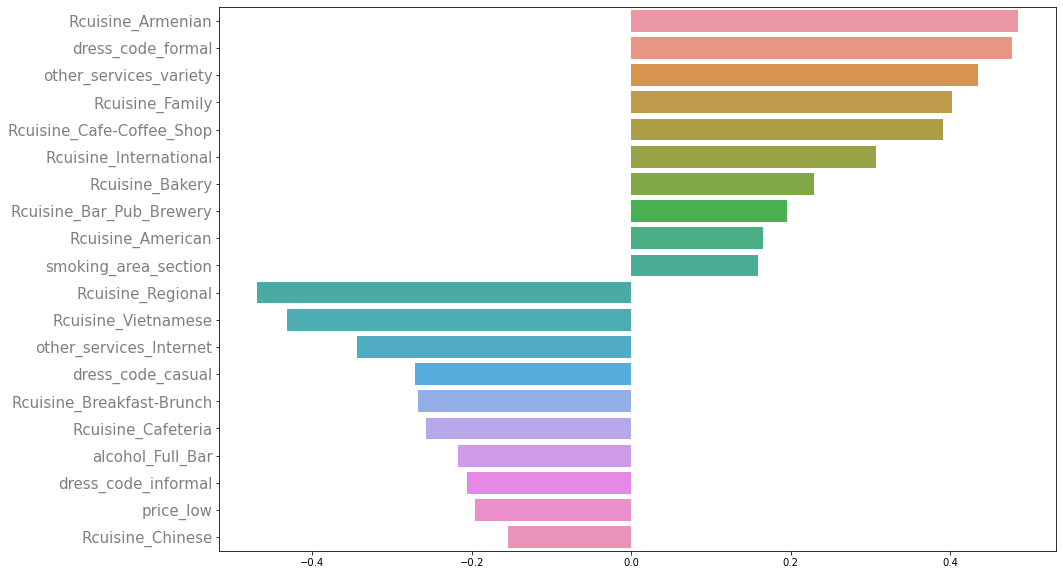

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

coef_high, coef_low = get_top_bottom_coef(lr_reg, n=10)
coef_concat = pd.concat([coef_high, coef_low])

plt.figure(figsize=(15, 10))
sns.barplot(x=coef_concat.values, y=coef_concat.index)
plt.yticks(fontsize =15, color='gray')


plt.show()

회귀계수 상위 10개에 대해 그려본 결과. 음식에 대해서 높은 중요도를 보이는 것을 알 수 있다.  
다만 음식종류가 많아, 정확한 지표라고 생각하기는 어렵다.  
dress_code, other_service정도 살펴볼 필요가 있어보인다.  

## boxplot

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
columns = list(total.columns)
columns.remove('placeID')
print(columns)
print(len(columns))
a = ['parking_lot', 'price', 'smoking_area', 'alcohol', 'dress_code', 'other_services', 'area', 'franchise', 'ambience']      

['mean_rating', 'rating', 'food_rating', 'service_rating', 'Rcuisine_American', 'Rcuisine_Armenian', 'Rcuisine_Bakery', 'Rcuisine_Bar', 'Rcuisine_Bar_Pub_Brewery', 'Rcuisine_Breakfast-Brunch', 'Rcuisine_Burgers', 'Rcuisine_Cafe-Coffee_Shop', 'Rcuisine_Cafeteria', 'Rcuisine_Chinese', 'Rcuisine_Contemporary', 'Rcuisine_Family', 'Rcuisine_Fast_Food', 'Rcuisine_Game', 'Rcuisine_International', 'Rcuisine_Italian', 'Rcuisine_Japanese', 'Rcuisine_Mexican', 'Rcuisine_Pizzeria', 'Rcuisine_Regional', 'Rcuisine_Seafood', 'Rcuisine_Vietnamese', 'parking_lot', 'price', 'smoking_area', 'alcohol', 'dress_code', 'other_services', 'area', 'franchise', 'ambience', 'latitude', 'longitude']
37


In [161]:
total['franchise'].value_counts()

f    67
t    18
Name: franchise, dtype: int64

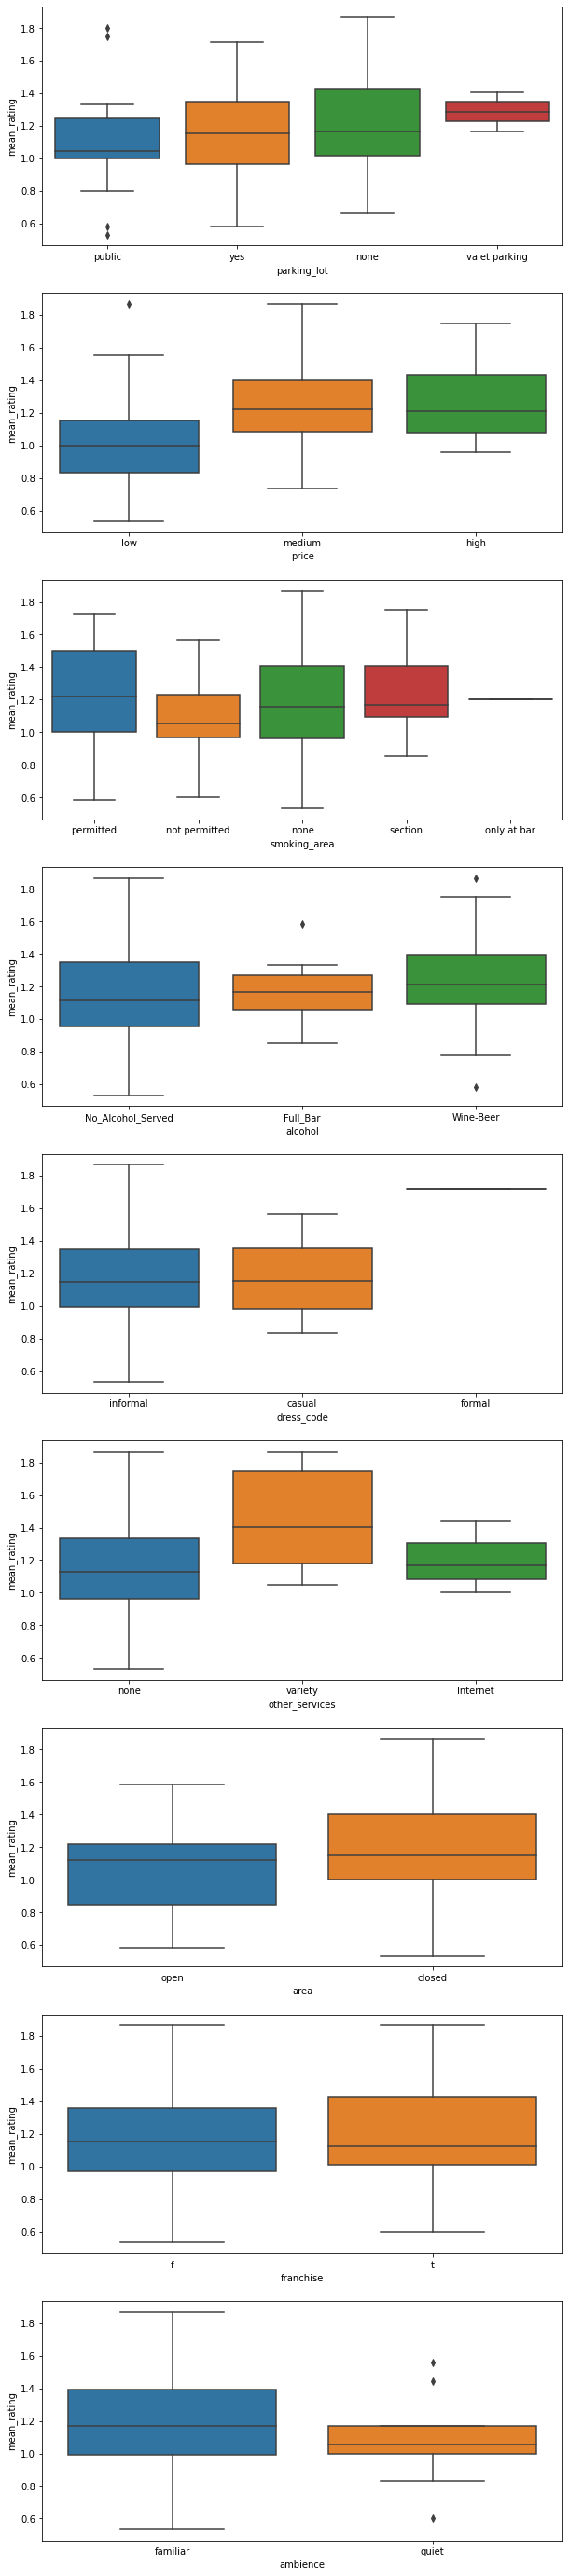

In [61]:
_ , axes = plt.subplots(9, figsize=(10, 50))
t = 0
for i in a:
    sns.boxplot(data=total, x=i, y='mean_rating', ax=axes[t])
    #axes[t].xaxis.label.set_color('white')
    t += 1

차이를 보이는 칼럼은 price, other_services. dress_code정도가 있곘다.  
다만 formal의 개수가 1개이기에 참고하기는 어려워보인다.

In [48]:
total['dress_code'].value_counts()

informal    76
casual       8
formal       1
Name: dress_code, dtype: int64

## mapping

In [8]:
rest_5 = pd.read_csv(dataPath + '/' + listDir[5]) # 가게 정보(이름, 위치, 위도, 경도, 가격)
rest_5 = rest_5[rest_5['placeID'].apply(lambda x : x in set_intersection)].reset_index(drop=True)
rest_5.rename(columns={'Rambience':'ambience'}, inplace=True)
rest_5 = rest_5.iloc[:, 0:3]
rest_5.sort_values(by='placeID', inplace=True)
rest_5.shape

(85, 3)

In [13]:
display(rating.head(), rest_5.head(), total.head())

,placeID,mean_rating
0,132560,0.583333
1,132572,0.977778
2,132584,1.277778
3,132594,0.800000
4,132608,1.000000


,placeID,latitude,longitude
69,132560,23.752304,-99.166913
57,132572,22.141647,-100.992712
77,132584,23.752365,-99.165288
72,132594,23.752168,-99.165709
26,132608,23.758805,-99.165130


,placeID,mean_rating,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,...,Rcuisine_Vietnamese,parking_lot,price,smoking_area,alcohol,dress_code,other_services,area,franchise,ambience
0,132560,0.583333,0,0,0,0,0,0,0,0,...,0,public,low,permitted,No_Alcohol_Served,informal,none,open,f,familiar
1,132572,0.977778,0,0,0,0,0,0,0,0,...,0,yes,low,not permitted,No_Alcohol_Served,informal,none,closed,f,familiar
2,132584,1.277778,0,0,0,0,0,0,0,0,...,0,yes,medium,not permitted,No_Alcohol_Served,informal,none,closed,t,familiar
3,132594,0.800000,0,0,0,0,0,0,0,0,...,0,public,low,not permitted,No_Alcohol_Served,informal,none,open,f,familiar
4,132608,1.000000,0,0,0,0,0,0,0,0,...,0,public,low,permitted,No_Alcohol_Served,informal,none,open,t,quiet


In [11]:
mapping = pd.concat([rating, rest_5.iloc[:, 1:3], total[['price', 'other_services']]], axis=1)
mapping.head()

,placeID,mean_rating,rating,food_rating,service_rating,latitude,longitude,price,other_services
0,132560,0.583333,0.500000,1.000000,0.250000,22.147392,-100.983092,low,none
1,132572,0.977778,1.000000,1.000000,0.933333,22.149709,-100.976093,low,none
2,132584,1.277778,1.333333,1.500000,1.000000,23.752697,-99.163359,medium,none
3,132594,0.800000,0.600000,1.200000,0.600000,23.752903,-99.165076,low,none
4,132608,1.000000,1.000000,1.166667,0.833333,23.754357,-99.171288,low,none


In [50]:
mapping['mean_rating'].describe()

count    85.000000
mean      1.174269
std       0.301870
min       0.533333
25%       1.000000
50%       1.151515
75%       1.388889
max       1.866667
Name: mean_rating, dtype: float64

In [12]:
mapping['rating'] = mapping['mean_rating'].apply(lambda x : '상' if type(x) == float and x >= 1.388889 else x)
mapping['rating'] = mapping['rating'].apply(lambda x : '중' if type(x) == float and x >= 1.151515 else x)
mapping['rating'] = mapping['rating'].apply(lambda x : '하' if type(x) == float else x)
mapping['rating'].value_counts()

하    42
중    22
상    21
Name: rating, dtype: int64

In [52]:
mapping['other_services'].unique()

array(['none', 'variety', 'Internet'], dtype=object)

In [51]:
mapping.head()

,placeID,mean_rating,latitude,longitude,price,other_services,rating
0,132560,0.583333,22.147392,-100.983092,low,none,하
1,132572,0.977778,22.149709,-100.976093,low,none,하
2,132584,1.277778,23.752697,-99.163359,medium,none,중
3,132594,0.800000,23.752903,-99.165076,low,none,하
4,132608,1.000000,23.754357,-99.171288,low,none,하


In [63]:
import folium # 평점 높은 가게 매핑해볼 수도 있겠다.

m = folium.Map(location=[22.087406, -100.472109])

a = mapping[mapping['rating']=='상']['latitude']
b = mapping[mapping['rating']=='상']['longitude']
c = mapping[mapping['rating']=='상']['placeID']

for i, j, k in (zip(a, b, c)):
    folium.Marker(
        location=[i, j],
        popup=k,
        icon=folium.Icon(color="red"),
    ).add_to(m)

a = mapping[mapping['rating']=='중']['latitude']
b = mapping[mapping['rating']=='중']['longitude']
c = mapping[mapping['rating']=='중']['placeID']

for i, j, k in (zip(a, b, c)):
    folium.Marker(
        location=[i, j],
        popup=k,
        icon=folium.Icon(color="blue"),
    ).add_to(m)


a = mapping[mapping['rating']=='하']['latitude']
b = mapping[mapping['rating']=='하']['longitude']
c = mapping[mapping['rating']=='하']['placeID']

for i, j, k in zip(a, b,c ):
    folium.Marker(
        location=[i, j],
        popup=k,
        icon=folium.Icon(color="green"),
    ).add_to(m)

a = mapping[mapping['price']=='high']['latitude']
b = mapping[mapping['price']=='high']['longitude']
c = mapping[mapping['price']=='high']['price']

for i, j, k in zip(a, b, c):
    folium.CircleMarker(
        location=[i, j],
        color='red',
        fill_color='red',
    ).add_to(m)
    
a = mapping[mapping['price']=='medium']['latitude']
b = mapping[mapping['price']=='medium']['longitude']
c = mapping[mapping['price']=='medium']['price']

for i, j, k in zip(a, b, c):
    folium.CircleMarker(
        location=[i, j],
        color='blue',
        fill_color='blue',
    ).add_to(m)
    
a = mapping[mapping['price']=='low']['latitude']
b = mapping[mapping['price']=='low']['longitude']
c = mapping[mapping['price']=='low']['price']

for i, j, k in zip(a, b, c):
    folium.CircleMarker(
        location=[i, j],
        color='green',
        fill_color='green',
        #radius=10,
    ).add_to(m)
m

In [49]:
m.save('C:/Users/mkk47/Desktop/map.html') #파일이 저장될 위치

### mapping결과 살펴보기

In [156]:
def find(placeID):
    return rest_5[rest_5['placeID']==placeID][['name','address', 'city', 'state', 'country']]

#### 대학가
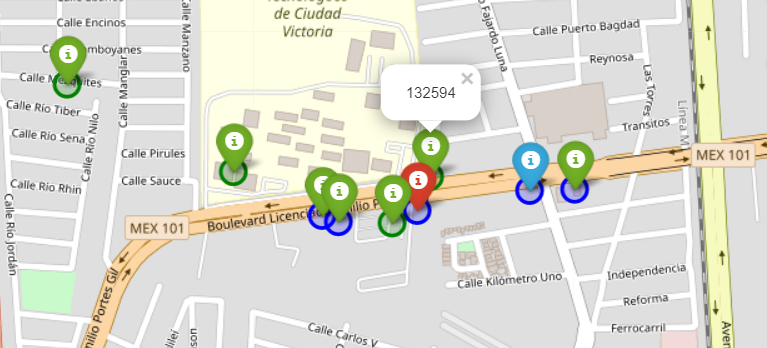

placeID: 132608, 132951, 135058, 135032, 135069, 132594, 132584,135043 

rating의 차이.   
- food_rating 
가지고 있는 지표로는 확인할 수가 없다.  
가장 낮은 음식점과 가장 높은 음식점은 같은 종류의 음식을 팔았고 둘 다 프랜차이즈 점이지만 점수에 차이가 있는 것으로 보아 음식의 맛이 영향을 미쳤다고 판단할 수 있어보인다.  
- service_rating 
높은 가게와 비교해봤을 때, area가 open일 경우(가게가 열려있는 형태)의 경우 더 낮은 형태를 보이는데, 이는 boxplot결과에서 얻은 결과와 비슷하다.  
이것 말고는 차이를 볼 수 없다. 이는 종업원의 친절도가 평가지표에서 빠졌기 때문이라고 판단된다.



In [78]:
pd.set_option('display.max_columns', 100)

In [148]:
ID = [132608, 132951, 135058, 135032, 135069, 132594, 132584,135043]

print('mean_ratinng:', total[total['placeID'].apply(lambda x : x in(ID))]['mean_rating'].mean())
print('ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['rating'].mean())
print('food_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['food_rating'].mean())
print('service_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['service_rating'].mean())

mean_ratinng: 0.971957671957672
ratinng: 0.9514880952380951
food_ratinng: 1.0561507936507937
service_ratinng: 0.908234126984127


In [126]:
ID = [132608, 132951, 135058, 135032, 135069, 132594, 132584,135043]

display(total[total['placeID'].apply(lambda x : x in(ID))].sort_values(by='mean_rating', ascending=False)
        , total[total['placeID']==135075])

,placeID,mean_rating,rating,food_rating,service_rating,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_Chinese,Rcuisine_Contemporary,Rcuisine_Family,Rcuisine_Fast_Food,Rcuisine_Game,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Mexican,Rcuisine_Pizzeria,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Vietnamese,parking_lot,price,smoking_area,alcohol,dress_code,other_services,area,franchise,ambience
2,132584,1.277778,1.333333,1.500000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,yes,medium,not permitted,No_Alcohol_Served,informal,none,closed,t,familiar
53,135032,1.107143,1.178571,1.071429,1.071429,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,public,medium,section,Wine-Beer,informal,none,closed,f,familiar
59,135043,1.037037,0.888889,1.111111,1.111111,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,none,medium,none,No_Alcohol_Served,informal,none,closed,f,familiar
69,135058,1.037037,1.111111,1.000000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,public,medium,none,No_Alcohol_Served,informal,none,closed,t,familiar
4,132608,1.000000,1.000000,1.166667,0.833333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,public,low,permitted,No_Alcohol_Served,informal,none,open,t,quiet
42,132951,0.933333,1.000000,0.900000,0.900000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,yes,low,not permitted,No_Alcohol_Served,casual,none,closed,f,familiar
3,132594,0.800000,0.600000,1.200000,0.600000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,public,low,not permitted,No_Alcohol_Served,informal,none,open,f,familiar
72,135069,0.583333,0.500000,0.500000,0.750000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,yes,low,none,Wine-Beer,informal,none,closed,f,familiar


,placeID,mean_rating,rating,food_rating,service_rating,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_Chinese,Rcuisine_Contemporary,Rcuisine_Family,Rcuisine_Fast_Food,Rcuisine_Game,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Mexican,Rcuisine_Pizzeria,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Vietnamese,parking_lot,price,smoking_area,alcohol,dress_code,other_services,area,franchise,ambience
77,135075,1.615385,1.692308,1.692308,1.461538,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,yes,medium,none,No_Alcohol_Served,informal,none,closed,f,familiar


In [158]:
find(135069)

,name,address,city,state,country
11,Abondance Restaurante Bar,Industrias 908 Valle Dorado,San Luis Potosi,SLP,Mexico


#### 호텔
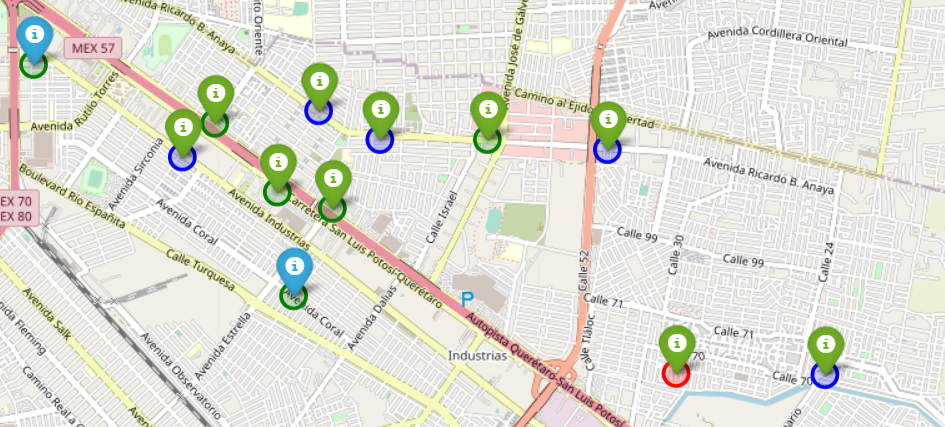

placeID: 132825, 132626, 135021, 132715, 132740, 132937, 132706, 135104, 132856, 132766, 134983, 132925

대부분 음식점수는 비슷하다. 서비스 점수에서 차이를 보인다.  
- service rating  
위와 마찬가지로 area가 open일 경우엔 점수가 낮은 경향을 보인다.  

In [147]:
ID = [132825, 132626, 135021, 132715, 132740, 132937, 132706, 135104, 132856, 132766, 134983, 132925]

print('mean_ratinng:', total[total['placeID'].apply(lambda x : x in(ID))]['mean_rating'].mean())
print('ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['rating'].mean())
print('food_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['food_rating'].mean())
print('service_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['service_rating'].mean())

mean_ratinng: 1.0133873456790121
ratinng: 1.0204613095238095
food_ratinng: 1.1438574735449734
service_ratinng: 0.8758432539682538


In [127]:
ID = [132825, 132626, 135021, 132715, 132740, 132937, 132706, 135104, 132856, 132766, 134983, 132925]

total[total['placeID'].apply(lambda x : x in(ID))].sort_values(by='mean_rating', ascending=False)

,placeID,mean_rating,rating,food_rating,service_rating,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_Chinese,Rcuisine_Contemporary,Rcuisine_Family,Rcuisine_Fast_Food,Rcuisine_Game,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Mexican,Rcuisine_Pizzeria,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Vietnamese,parking_lot,price,smoking_area,alcohol,dress_code,other_services,area,franchise,ambience
22,132825,1.187500,1.281250,1.343750,0.937500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,none,low,none,No_Alcohol_Served,informal,none,open,f,familiar
41,132937,1.166667,1.500000,1.000000,1.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,none,low,section,Full_Bar,informal,variety,closed,f,quiet
40,132925,1.133333,1.000000,1.200000,1.200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,none,medium,not permitted,Wine-Beer,informal,none,closed,f,familiar
7,132626,1.083333,1.250000,1.000000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,yes,medium,none,No_Alcohol_Served,informal,none,closed,t,familiar
46,134983,1.066667,1.000000,1.000000,1.200000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,yes,high,section,Full_Bar,informal,none,closed,f,familiar
82,135104,1.047619,0.857143,1.428571,0.857143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,yes,medium,not permitted,Full_Bar,informal,variety,closed,t,familiar
48,135021,1.037037,1.333333,1.111111,0.666667,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,public,low,not permitted,No_Alcohol_Served,informal,none,closed,t,familiar
9,132706,1.000000,0.750000,1.250000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,public,medium,not permitted,No_Alcohol_Served,informal,none,closed,t,familiar
28,132856,0.952381,0.857143,1.142857,0.857143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,none,low,none,Wine-Beer,informal,none,closed,f,familiar
15,132740,0.875000,0.750000,1.250000,0.625000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,none,low,permitted,No_Alcohol_Served,informal,none,open,f,familiar


#### 대학+공원+호텔
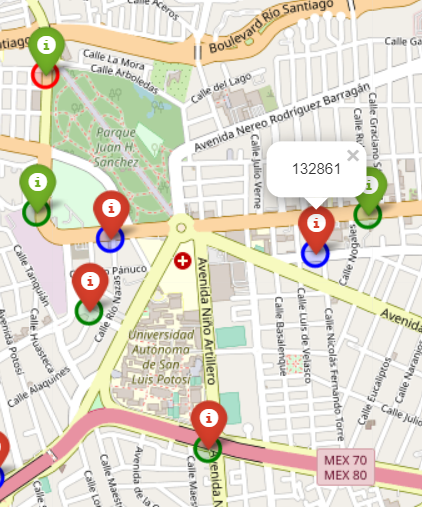

placeID: 135053, 132885, 135028,132958,132667,132861,132870

- 대학가 + 공원이다보니 가격대가 낮고 편안함을 추구하는 경향이 있음
- 

In [146]:
ID = [135053, 132885, 135028,132958,132667,132861,132870]

print('mean_ratinng:', total[total['placeID'].apply(lambda x : x in(ID))]['mean_rating'].mean())
print('ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['rating'].mean())
print('food_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['food_rating'].mean())
print('service_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['service_rating'].mean())

mean_ratinng: 1.1557256235827664
ratinng: 1.1719387755102042
food_ratinng: 1.2959183673469388
service_ratinng: 0.9993197278911564


In [159]:
ID = [135053, 132885, 135028,132958,132667,132861,132870]

total[total['placeID'].apply(lambda x : x in(ID))].sort_values(by='mean_rating', ascending=False)

,placeID,mean_rating,rating,food_rating,service_rating,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_Chinese,Rcuisine_Contemporary,Rcuisine_Family,Rcuisine_Fast_Food,Rcuisine_Game,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Mexican,Rcuisine_Pizzeria,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Vietnamese,parking_lot,price,smoking_area,alcohol,dress_code,other_services,area,franchise,ambience
45,132958,1.555556,1.666667,1.500000,1.500000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,none,low,none,No_Alcohol_Served,informal,none,closed,t,quiet
8,132667,1.500000,1.250000,2.000000,1.250000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,none,low,none,No_Alcohol_Served,informal,none,closed,t,familiar
30,132861,1.476190,1.428571,1.571429,1.428571,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,yes,medium,not permitted,No_Alcohol_Served,informal,none,closed,t,familiar
51,135028,1.400000,1.533333,1.400000,1.266667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,none,medium,none,Wine-Beer,informal,none,closed,f,familiar
65,135053,0.958333,1.125000,1.000000,0.750000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,yes,high,section,No_Alcohol_Served,informal,none,closed,f,familiar
34,132870,0.666667,0.600000,1.000000,0.400000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,none,low,not permitted,No_Alcohol_Served,informal,none,closed,f,familiar
37,132885,0.533333,0.600000,0.600000,0.400000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,public,low,none,No_Alcohol_Served,informal,none,closed,f,familiar


#### 병원
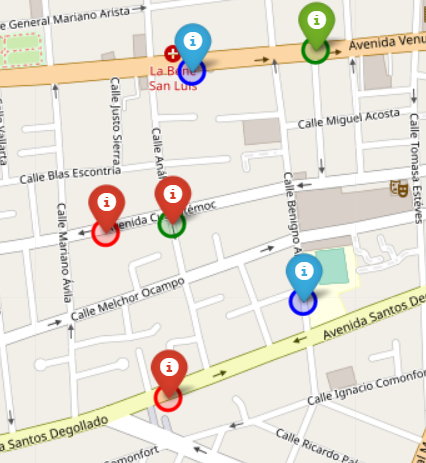

plcaeID: 135074, 132773, 132862, 135085, 135060, 132732

- price가 다양하게 분포하는 것으로 보아 환자의 재정상태에 따라 다양한 금액대의 음식점이 분포함
- 특이한 점은 주류를 제공하는 음식점이 모두 점수가 높음

In [145]:
ID = [135074, 132773, 132862, 135085, 135060, 132732]

print('mean_ratinng:', total[total['placeID'].apply(lambda x : x in(ID))]['mean_rating'].mean())
print('ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['rating'].mean())
print('food_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['food_rating'].mean())
print('service_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['service_rating'].mean())

mean_ratinng: 1.3277216610549945
ratinng: 1.2889309764309764
food_ratinng: 1.2969276094276094
service_ratinng: 1.3973063973063973


In [130]:
ID = [135074, 132773, 132862, 135085, 135060, 132732]

total[total['placeID'].apply(lambda x : x in(ID))].sort_values(by='mean_rating', ascending=False)

,placeID,mean_rating,rating,food_rating,service_rating,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_Chinese,Rcuisine_Contemporary,Rcuisine_Family,Rcuisine_Fast_Food,Rcuisine_Game,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Mexican,Rcuisine_Pizzeria,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Vietnamese,parking_lot,price,smoking_area,alcohol,dress_code,other_services,area,franchise,ambience
76,135074,1.750000,1.750000,1.750000,1.750000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,public,high,section,Wine-Beer,informal,none,closed,f,familiar
21,132773,1.500000,1.500000,1.250000,1.750000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,none,low,permitted,Wine-Beer,informal,none,open,f,familiar
31,132862,1.407407,1.388889,1.388889,1.444444,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,valet parking,high,none,Wine-Beer,casual,none,closed,f,familiar
79,135085,1.324074,1.333333,1.472222,1.166667,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,public,medium,not permitted,No_Alcohol_Served,informal,none,closed,f,familiar
71,135060,1.151515,1.136364,1.045455,1.272727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,none,medium,none,No_Alcohol_Served,informal,none,closed,f,familiar
13,132732,0.833333,0.625000,0.875000,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,none,low,none,No_Alcohol_Served,casual,none,open,f,familiar


#### 쇼핑몰
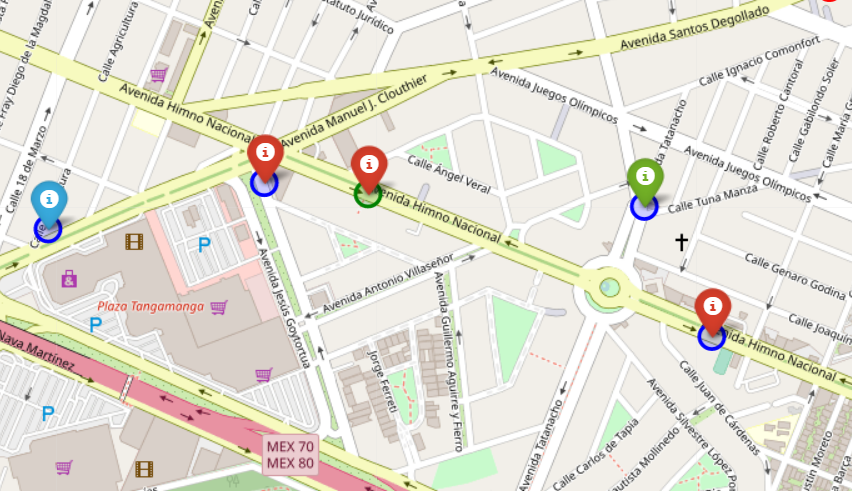

placeID: 132854, 135025, 132955, 135041, 135059

- 다른 지역보다 평균 점수가 높음
- 가격대가 소~중 사이고, 대부분이 중으로 형성되어 있음
- 

In [143]:
ID = [132854, 135025, 132955, 135041, 135059]

print('mean_ratinng:', total[total['placeID'].apply(lambda x : x in(ID))]['mean_rating'].mean())
print('ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['rating'].mean())
print('food_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['food_rating'].mean())
print('service_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['service_rating'].mean())

mean_ratinng: 1.486492374727669
ratinng: 1.5686274509803924
food_ratinng: 1.5108496732026144
service_ratinng: 1.38


In [141]:
ID = [132854, 135025, 132955, 135041, 135059]

total[total['placeID'].apply(lambda x : x in(ID))].sort_values(by='mean_rating', ascending=False)

,placeID,mean_rating,rating,food_rating,service_rating,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_Chinese,Rcuisine_Contemporary,Rcuisine_Family,Rcuisine_Fast_Food,Rcuisine_Game,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Mexican,Rcuisine_Pizzeria,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Vietnamese,parking_lot,price,smoking_area,alcohol,dress_code,other_services,area,franchise,ambience
44,132955,1.866667,2.000000,1.800000,1.800000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,none,low,none,Wine-Beer,informal,variety,closed,t,familiar
49,135025,1.577778,1.666667,1.466667,1.600000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,none,medium,none,No_Alcohol_Served,informal,none,closed,f,familiar
70,135059,1.481481,1.666667,1.444444,1.333333,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,yes,medium,section,Wine-Beer,informal,none,closed,f,familiar
27,132854,1.388889,1.333333,1.666667,1.166667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,yes,medium,none,Wine-Beer,informal,none,closed,f,familiar
57,135041,1.117647,1.176471,1.176471,1.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,none,medium,none,Wine-Beer,informal,none,closed,f,familiar


#### 미술관, 박물관
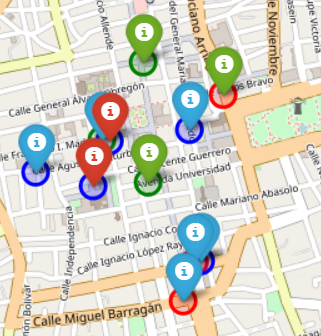

placeID: 132717, 132768, 132922, 132846, 132572, 135057, 135048, 135052, 132723, 132858, 135079

- 관광지 답게 대부분의 음식점이 프랜차이즈 점이다
- 그래서 그런지 대부분

In [144]:
ID = [132717, 132768, 132922, 132846, 132572, 135057, 135048, 135052, 132723, 132858, 135079]

print('mean_ratinng:', total[total['placeID'].apply(lambda x : x in(ID))]['mean_rating'].mean())
print('ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['rating'].mean())
print('food_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['food_rating'].mean())
print('service_ratinng:',total[total['placeID'].apply(lambda x : x in(ID))]['service_rating'].mean())

mean_ratinng: 1.26369578134284
ratinng: 1.2824064171122993
food_ratinng: 1.328270944741533
service_ratinng: 1.1804099821746883


In [132]:
ID = [132717, 132768, 132922, 132846, 132572, 135057, 135048, 135052, 132723, 132858, 135079]

total[total['placeID'].apply(lambda x : x in(ID))].sort_values(by='mean_rating', ascending=False)

,placeID,mean_rating,rating,food_rating,service_rating,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,Rcuisine_Breakfast-Brunch,Rcuisine_Burgers,Rcuisine_Cafe-Coffee_Shop,Rcuisine_Cafeteria,Rcuisine_Chinese,Rcuisine_Contemporary,Rcuisine_Family,Rcuisine_Fast_Food,Rcuisine_Game,Rcuisine_International,Rcuisine_Italian,Rcuisine_Japanese,Rcuisine_Mexican,Rcuisine_Pizzeria,Rcuisine_Regional,Rcuisine_Seafood,Rcuisine_Vietnamese,parking_lot,price,smoking_area,alcohol,dress_code,other_services,area,franchise,ambience
39,132922,1.722222,1.833333,1.500000,1.833333,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,none,medium,permitted,No_Alcohol_Served,formal,none,closed,f,familiar
20,132768,1.566667,1.600000,1.700000,1.400000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,none,medium,not permitted,No_Alcohol_Served,casual,none,closed,t,familiar
25,132846,1.333333,1.400000,1.400000,1.200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,none,low,permitted,No_Alcohol_Served,casual,none,open,f,familiar
12,132723,1.333333,1.416667,1.333333,1.250000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,public,medium,section,Full_Bar,informal,none,closed,f,familiar
68,135057,1.311111,1.266667,1.333333,1.333333,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,yes,medium,section,Wine-Beer,informal,none,closed,f,familiar
11,132717,1.222222,1.333333,1.333333,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,public,medium,not permitted,No_Alcohol_Served,informal,none,closed,f,familiar
62,135048,1.222222,1.000000,1.333333,1.333333,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,yes,high,none,Wine-Beer,informal,none,closed,f,familiar
64,135052,1.200000,1.280000,1.160000,1.160000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,none,high,none,Full_Bar,informal,none,closed,f,familiar
78,135079,1.078431,1.176471,1.117647,0.941176,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,none,high,none,No_Alcohol_Served,informal,none,closed,f,familiar
1,132572,0.977778,1.000000,1.000000,0.933333,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,yes,low,not permitted,No_Alcohol_Served,informal,none,closed,f,familiar


In [175]:
find(132922)

,name,address,city,state,country
95,cafe punta del cielo,?,?,?,?


In [174]:
find(132858)

,name,address,city,state,country
68,Hamburguesas Valle Dorado,Av. Coral,San Luis Potosi,San Luis Potosi,Mexico


## PCA

주요요소분석.

다른 축을 찾는 것. 

In [164]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_features)

In [166]:
pca_columns = ['pca_component_1', 'pca_component_2']
pca_df = pd.DataFrame(pca_components, columns=pca_columns)
pca_df['rating'] = mapping['rating']
pca_df

,pca_component_1,pca_component_2,rating
0,0.523152,1.150189,하
1,-0.661252,0.430014,하
2,-1.536564,0.329889,중
3,0.140011,1.396344,하
4,0.196429,1.874369,하
...,...,...,...
80,-1.764921,0.224406,하
81,-0.266328,1.090830,하
82,-1.251535,-0.230075,하
83,1.034963,-0.162544,중


In [168]:
import warnings
warnings.filterwarnings('ignore')

In [171]:
plt.rc("font", family="Malgun Gothic") #한글폰트설정
plt.rc("axes", unicode_minus=False) #-깨지는거 수정해주기

In [173]:
pca.explained_variance_ratio_ 

array([0.1390763 , 0.12824761])

상관도가 매우 적기에 pca를 적용하기 어려워 보인다.

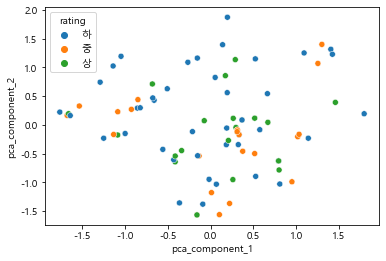

In [172]:
sns.scatterplot(data=pca_df, x='pca_component_1', y='pca_component_2', hue='rating')
plt.show()